In [7]:
import torch
import gpytorch
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from torch.utils.data import TensorDataset, DataLoader

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

M = 500               
batch_size = 512      
training_iter = 500    
learning_rate = 0.01

housing = fetch_california_housing()
X, y = housing.data, housing.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

train_x = torch.tensor(X_train, dtype=torch.float32).to(device)
train_y = torch.tensor(y_train, dtype=torch.float32).to(device)
test_x = torch.tensor(X_test, dtype=torch.float32).to(device)
test_y = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

from gpytorch.variational import (
    VariationalStrategy,
    CholeskyVariationalDistribution
)
from gpytorch.models import ApproximateGP

class SVGPRegressionModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

num_train = train_x.size(0)
M = min(M, num_train)
inducing_idx = torch.randperm(num_train)[:M]
inducing_points = train_x[inducing_idx].clone()

model = SVGPRegressionModel(inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=num_train)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=learning_rate)

model.train()
likelihood.train()

print("Training SVGP...")
for epoch in range(1, training_iter + 1):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)  
    if epoch % 50 == 0 or epoch == 1:
        avg_loss = epoch_loss / num_train
        print(f"Epoch {epoch}/{training_iter} - Avg Loss: {avg_loss:.6f}")

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))
    gp_mean = preds.mean.cpu().numpy()
    gp_var = preds.variance.cpu().numpy()

gp_mse = mean_squared_error(y_test, gp_mean)
gp_rmse = np.sqrt(gp_mse)
print(f"\nSVGP - MSE: {gp_mse:.4f} | RMSE: {gp_rmse:.4f}")
print("\nTraining sklearn / XGBoost baselines (this runs on CPU)...")
X_train_np = X_train  
X_test_np = X_test
y_train_np = y_train
y_test_np = y_test

reg_models = {
    'Random Forest': RandomForestRegressor(random_state=seed, n_jobs=-1),
    'Support Vector Regression': SVR(),
    'XGBoost': XGBRegressor(random_state=seed, verbosity=0),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=seed)
}

mse_results = {'SVGP (gpytorch)': gp_mse}
rmse_results = {'SVGP (gpytorch)': gp_rmse}

for name, model_sk in reg_models.items():
    model_sk.fit(X_train_np, y_train_np)
    pred = model_sk.predict(X_test_np)
    mse = mean_squared_error(y_test_np, pred)
    rmse = np.sqrt(mse)
    mse_results[name] = mse
    rmse_results[name] = rmse
    print(f"{name:30} MSE: {mse:.4f} | RMSE: {rmse:.4f}")

print(f"\nPredictive variance (test): mean={gp_var.mean():.6f} std={gp_var.std():.6f}")

Device: cuda
Training SVGP...
Epoch 1/500 - Avg Loss: 3.593769
Epoch 50/500 - Avg Loss: 0.917319
Epoch 100/500 - Avg Loss: 0.909974
Epoch 150/500 - Avg Loss: 0.913013
Epoch 200/500 - Avg Loss: 0.904834
Epoch 250/500 - Avg Loss: 0.902749
Epoch 300/500 - Avg Loss: 0.899675
Epoch 350/500 - Avg Loss: 0.900817
Epoch 400/500 - Avg Loss: 0.899273
Epoch 450/500 - Avg Loss: 0.899198
Epoch 500/500 - Avg Loss: 0.897343

SVGP - MSE: 0.3221 | RMSE: 0.5675

Training sklearn / XGBoost baselines (this runs on CPU)...
Random Forest                  MSE: 0.2555 | RMSE: 0.5055
Support Vector Regression      MSE: 0.3552 | RMSE: 0.5960
XGBoost                        MSE: 0.2226 | RMSE: 0.4718
MLP                            MSE: 0.2700 | RMSE: 0.5196

Predictive variance (test): mean=0.341420 std=0.078347


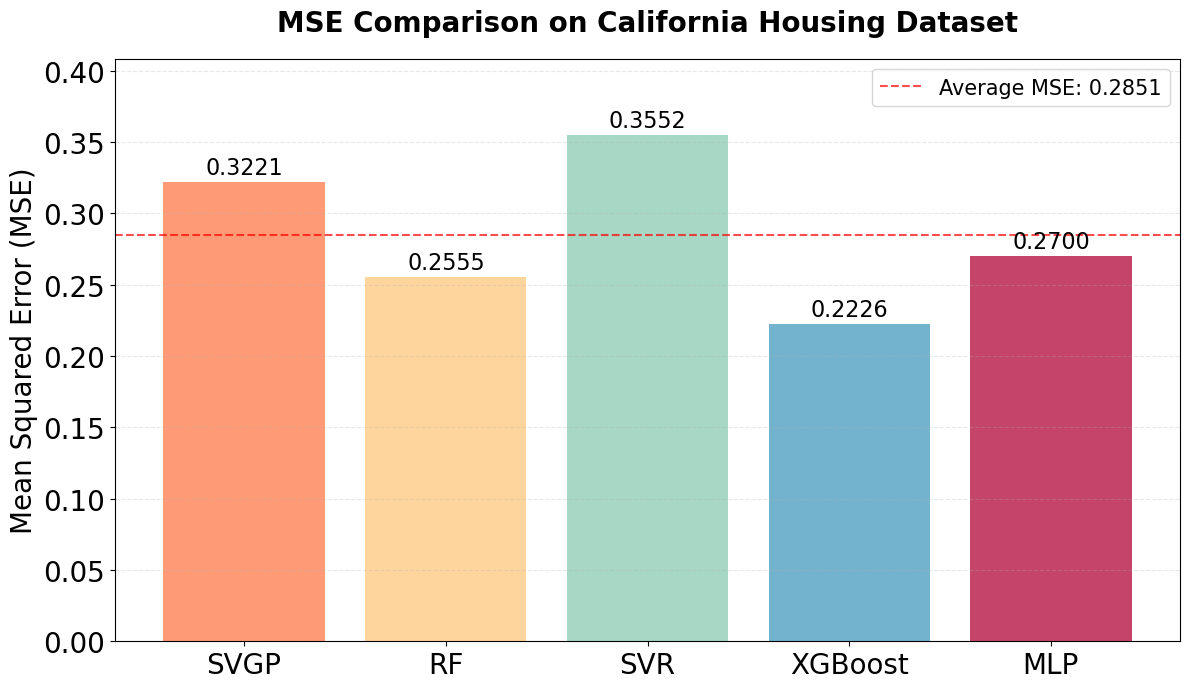

In [15]:
import matplotlib.pyplot as plt
import numpy as np

mse_results = {
    'SVGP': 0.3221, 
    'RF': 0.2555,    
    'SVR': 0.3552,  
    'XGBoost': 0.2226,          
    'MLP': 0.2700                
}

models = list(mse_results.keys())
mse_values = list(mse_results.values())

plt.figure(figsize=(12, 7))
bars = plt.bar(models, mse_values, color=['#FF9A76', '#FFD59E', '#A7D7C5', '#74B3CE', '#C44569'])

for bar, value in zip(bars, mse_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{value:.4f}', ha='center', va='bottom', fontsize=16)

plt.title('MSE Comparison on California Housing Dataset', 
          fontsize=20, fontweight='bold', pad=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.ylim(0, max(mse_values) * 1.15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.axhline(y=np.mean(mse_values), color='r', linestyle='--', alpha=0.7, 
            label=f'Average MSE: {np.mean(mse_values):.4f}')
plt.legend(fontsize=15) 

plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

M = 500                
batch_size = 512       
training_iter = 500 
learning_rate = 0.01

import numpy as np
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X = data.data
y = data.target

y_new = np.where(X[:, 0] > X[:, 0].mean(),
                 np.log1p(X[:, 1])**2 + np.sin(X[:, 2]*5),
                 np.sqrt(X[:, 3]) + np.sign(X[:, 4]-X[:,4].mean()))
y = y_new

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

train_x = torch.tensor(X_train, dtype=torch.float32).to(device)
train_y = torch.tensor(y_train, dtype=torch.float32).to(device)
test_x = torch.tensor(X_test, dtype=torch.float32).to(device)
test_y = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_train = train_x.size(0)
M = min(M, num_train)
inducing_idx = torch.randperm(num_train)[:M]
inducing_points = train_x[inducing_idx].clone()

model = SVGPRegressionModel(inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=num_train)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=learning_rate)

model.train()
likelihood.train()

print("Training SVGP...")
for epoch in range(1, training_iter + 1):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)  
    if epoch % 100 == 0 or epoch == 1:
        avg_loss = epoch_loss / num_train
        print(f"Epoch {epoch}/{training_iter} - Avg Loss: {avg_loss:.6f}")

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))
    gp_mean = preds.mean.cpu().numpy()
    gp_var = preds.variance.cpu().numpy()

gp_mse = mean_squared_error(y_test, gp_mean)
gp_rmse = np.sqrt(gp_mse)
print(f"\nSVGP - MSE: {gp_mse:.4f} | RMSE: {gp_rmse:.4f}")

print("\nTraining sklearn / XGBoost baselines (this runs on CPU)...")
X_train_np = X_train  
X_test_np = X_test
y_train_np = y_train
y_test_np = y_test

reg_models = {
    'Random Forest': RandomForestRegressor(random_state=seed, n_jobs=-1),
    'Support Vector Regression': SVR(),
    'XGBoost': XGBRegressor(random_state=seed, verbosity=0),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=seed)
}

mse_results = {'SVGP (gpytorch)': gp_mse}
rmse_results = {'SVGP (gpytorch)': gp_rmse}

for name, model_sk in reg_models.items():
    model_sk.fit(X_train_np, y_train_np)
    pred = model_sk.predict(X_test_np)
    mse = mean_squared_error(y_test_np, pred)
    rmse = np.sqrt(mse)
    mse_results[name] = mse
    rmse_results[name] = rmse
    print(f"{name:30} MSE: {mse:.4f} | RMSE: {rmse:.4f}")

print(f"\nPredictive variance (test): mean={gp_var.mean():.6f} std={gp_var.std():.6f}")

Device: cuda
Training SVGP...
Epoch 1/500 - Avg Loss: 31.296252
Epoch 100/500 - Avg Loss: 2.259851
Epoch 200/500 - Avg Loss: 2.224126
Epoch 300/500 - Avg Loss: 2.218955
Epoch 400/500 - Avg Loss: 2.217916
Epoch 500/500 - Avg Loss: 2.215588

SVGP - MSE: 4.0781 | RMSE: 2.0194

Training sklearn / XGBoost baselines (this runs on CPU)...
Random Forest                  MSE: 0.0246 | RMSE: 0.1568
Support Vector Regression      MSE: 6.5550 | RMSE: 2.5603
XGBoost                        MSE: 0.0422 | RMSE: 0.2053
MLP                            MSE: 0.3879 | RMSE: 0.6228

Predictive variance (test): mean=4.740412 std=0.634065


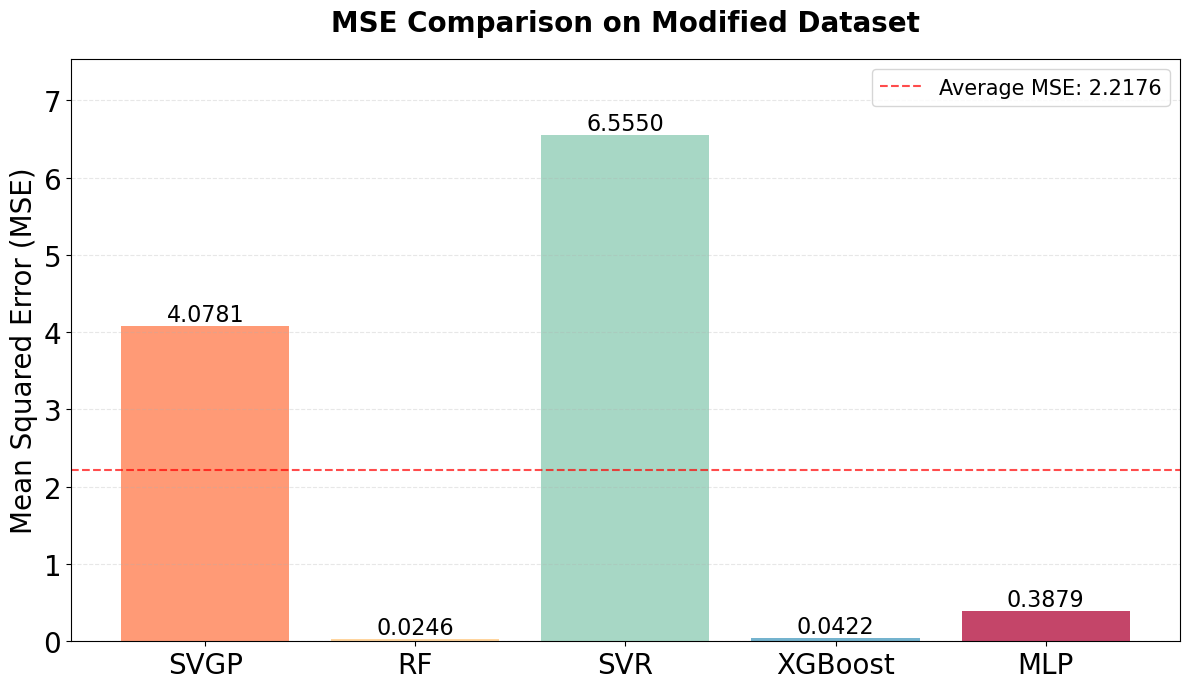

In [14]:
mse_results = {
    'SVGP': 4.0781,  
    'RF': 0.0246,    
    'SVR': 6.5550,  
    'XGBoost': 0.0422,           
    'MLP': 0.3879               
}

models = list(mse_results.keys())
mse_values = list(mse_results.values())

plt.figure(figsize=(12, 7))
bars = plt.bar(models, mse_values, color=['#FF9A76', '#FFD59E', '#A7D7C5', '#74B3CE', '#C44569'])

for bar, value in zip(bars, mse_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{value:.4f}', ha='center', va='bottom', fontsize=16)

plt.title('MSE Comparison on Modified Dataset', 
          fontsize=20, fontweight='bold', pad=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.ylim(0, max(mse_values) * 1.15)
plt.xticks( fontsize=20)
plt.yticks(fontsize=20)

plt.axhline(y=np.mean(mse_values), color='r', linestyle='--', alpha=0.7, 
            label=f'Average MSE: {np.mean(mse_values):.4f}')
plt.legend(fontsize=15) 

plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
import gpytorch
from gpytorch.models import ApproximateGP
import torch
import gpytorch
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from torch.utils.data import TensorDataset, DataLoader

class SVGPRegressionModel_Matern(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        # Matern kernel, ν=0.5
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=0.5)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

M = 500               
batch_size = 512      
training_iter = 500 
learning_rate = 0.01

import numpy as np
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X = data.data
y = data.target

y_new = np.where(X[:, 0] > X[:, 0].mean(),
                 np.log1p(X[:, 1])**2 + np.sin(X[:, 2]*5),
                 np.sqrt(X[:, 3]) + np.sign(X[:, 4]-X[:,4].mean()))
y = y_new

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

train_x = torch.tensor(X_train, dtype=torch.float32).to(device)
train_y = torch.tensor(y_train, dtype=torch.float32).to(device)
test_x = torch.tensor(X_test, dtype=torch.float32).to(device)
test_y = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_train = train_x.size(0)
M = min(M, num_train)
inducing_idx = torch.randperm(num_train)[:M]
inducing_points = train_x[inducing_idx].clone()

model = SVGPRegressionModel_Matern(inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=num_train)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=learning_rate)

model.train()
likelihood.train()

print("Training SVGP(Matern)...")
for epoch in range(1, training_iter + 1):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)  
    if epoch % 100 == 0 or epoch == 1:
        avg_loss = epoch_loss / num_train
        print(f"Epoch {epoch}/{training_iter} - Avg Loss: {avg_loss:.6f}")

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))
    gp_mean = preds.mean.cpu().numpy()
    gp_var = preds.variance.cpu().numpy()

gp_mse = mean_squared_error(y_test, gp_mean)
gp_rmse = np.sqrt(gp_mse)
print(f"\nSVGP(Matern) - MSE: {gp_mse:.4f} | RMSE: {gp_rmse:.4f}")

print("\nTraining sklearn / XGBoost baselines (this runs on CPU)...")
X_train_np = X_train  
X_test_np = X_test
y_train_np = y_train
y_test_np = y_test

reg_models = {
    'Random Forest': RandomForestRegressor(random_state=seed, n_jobs=-1),
    'Support Vector Regression': SVR(),
    'XGBoost': XGBRegressor(random_state=seed, verbosity=0),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=seed)
}

mse_results = {'SVGP (gpytorch)': gp_mse}
rmse_results = {'SVGP (gpytorch)': gp_rmse}

for name, model_sk in reg_models.items():
    model_sk.fit(X_train_np, y_train_np)
    pred = model_sk.predict(X_test_np)
    mse = mean_squared_error(y_test_np, pred)
    rmse = np.sqrt(mse)
    mse_results[name] = mse
    rmse_results[name] = rmse
    print(f"{name:30} MSE: {mse:.4f} | RMSE: {rmse:.4f}")

print(f"\nPredictive variance (test): mean={gp_var.mean():.6f} std={gp_var.std():.6f}")

Device: cuda
Training SVGP(Matern)...
Epoch 1/500 - Avg Loss: 31.153258
Epoch 100/500 - Avg Loss: 2.245597
Epoch 200/500 - Avg Loss: 2.216834
Epoch 300/500 - Avg Loss: 2.207294
Epoch 400/500 - Avg Loss: 2.204242
Epoch 500/500 - Avg Loss: 2.202303

SVGP(Matern) - MSE: 3.5974 | RMSE: 1.8967

Training sklearn / XGBoost baselines (this runs on CPU)...
Random Forest                  MSE: 0.0246 | RMSE: 0.1568
Support Vector Regression      MSE: 6.5550 | RMSE: 2.5603
XGBoost                        MSE: 0.0422 | RMSE: 0.2053
MLP                            MSE: 0.3879 | RMSE: 0.6228

Predictive variance (test): mean=4.660684 std=0.374907


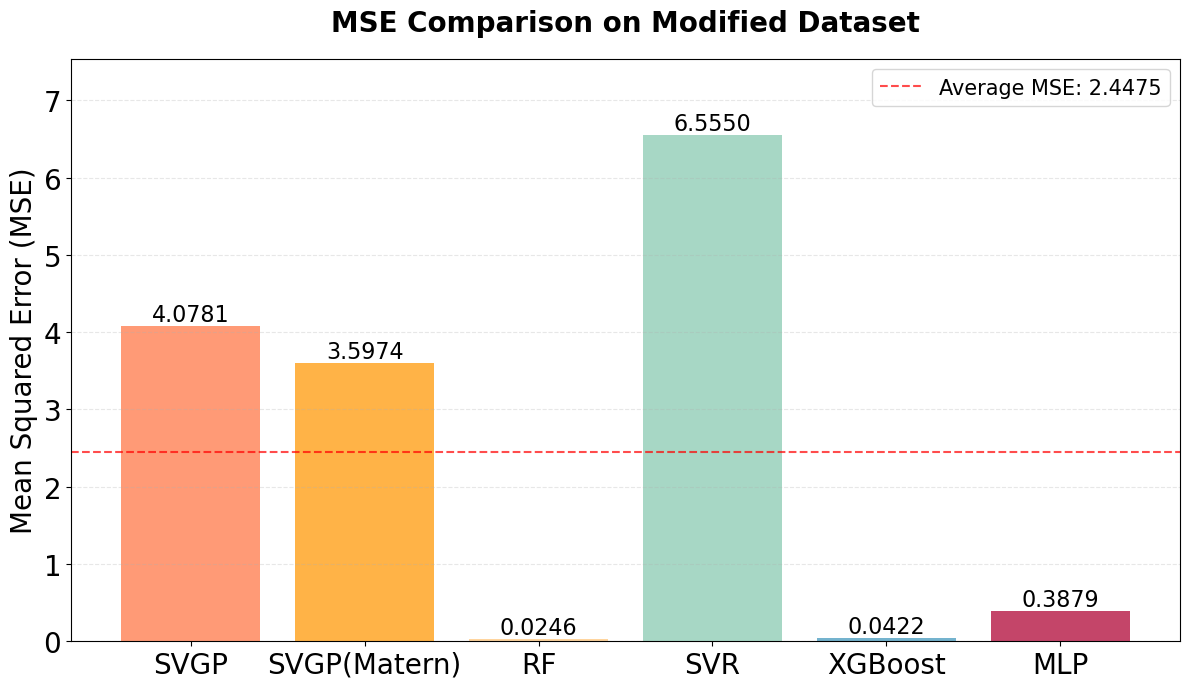

In [12]:
mse_results = {
    'SVGP': 4.0781,  
    'SVGP(Matern)': 3.5974, 
    'RF': 0.0246,    
    'SVR': 6.5550,  
    'XGBoost': 0.0422,           
    'MLP': 0.3879               
}

models = list(mse_results.keys())
mse_values = list(mse_results.values())

plt.figure(figsize=(12, 7))
bars = plt.bar(models, mse_values, color=['#FF9A76', '#FFB347', '#FFD59E', '#A7D7C5', '#74B3CE', '#C44569'])

for bar, value in zip(bars, mse_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{value:.4f}', ha='center', va='bottom', fontsize=16)

plt.title('MSE Comparison on Modified Dataset', 
          fontsize=20, fontweight='bold', pad=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.ylim(0, max(mse_values) * 1.15)
plt.xticks( fontsize=20)
plt.yticks(fontsize=20)

plt.axhline(y=np.mean(mse_values), color='r', linestyle='--', alpha=0.7, 
            label=f'Average MSE: {np.mean(mse_values):.4f}')
plt.legend(fontsize=15) 

plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()